In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from physics import *

# Physics & Catastrophes

## Lagrangian <-> Hamiltonian Conversion

### 1D Standard Harmonic Oscillator

In [4]:
x, u, p = sp.symbols('x u p', real=True)
L_ho = 0.5 * p**2 - 0.5 * u**2

try:
    H_ho, (xi,) = LagrangianHamiltonianConverter.L_to_H(L_ho, (x,), u, (p,))
    print(f"  L = {L_ho}")
    print(f"  H (computed) = {H_ho}")
    print(f"  H (expected) = 1/2 xi^2 + 1/2 u^2")
    print(f"  Match: {sp.simplify(H_ho - (0.5 * xi**2 + 0.5 * u**2)) == 0}")
except Exception as e:
    print(f"  FAILED: {e}")

  L = 0.5*p**2 - 0.5*u**2
  H (computed) = 0.5*u**2 + 0.5*xi**2
  H (expected) = 1/2 xi^2 + 1/2 u^2
  Match: True


### 2D Free Particle

In [5]:
x, y, u, p_x, p_y = sp.symbols('x y u p_x p_y', real=True)
L_free = 0.5 * (p_x**2 + p_y**2)

try:
    H_free, (xi, eta) = LagrangianHamiltonianConverter.L_to_H(L_free, (x, y), u, (p_x, p_y))
    print(f"  L = {L_free}")
    print(f"  H (computed) = {H_free}")
    print(f"  H (expected) = 1/2 (xi^2 + eta^2)")
    print(f"  Match: {sp.simplify(H_free - 0.5 * (xi**2 + eta**2)) == 0}")
except Exception as e:
    print(f"  FAILED: {e}")

  L = 0.5*p_x**2 + 0.5*p_y**2
  H (computed) = 0.5*eta**2 + 0.5*xi**2
  H (expected) = 1/2 (xi^2 + eta^2)
  Match: True


### L -> H -> L Consistency (Harmonic Oscillator)

In [6]:
# Convert L -> H, then H -> L and check if we get back the original L (up to constant or sign)
try:
    L_orig = L_ho
    H_temp, (xi,) = LagrangianHamiltonianConverter.L_to_H(L_orig, (x,), u, (p,))
    L_back, (p_back,) = LagrangianHamiltonianConverter.H_to_L(H_temp, (x,), u, (xi,))
    print(f"  Original L = {L_orig}")
    print(f"  Reconstructed L = {L_back}")
    print(f"  Match: {sp.simplify(L_orig - L_back) == 0}")
except Exception as e:
    print(f"  FAILED: {e} (This might be expected due to asymmetry in H_to_L, see analysis)")

  Original L = 0.5*p**2 - 0.5*u**2
  Reconstructed L = 0.5*p**2 - 0.5*u**2
  Match: True


### L with Singular Hessian (p^4) - L->H failure

In [7]:
L_bad = p**4
try:
    H_bad, _ = LagrangianHamiltonianConverter.L_to_H(L_bad, (x,), u, (p,))
    print(f"  UNEXPECTED SUCCESS: H = {H_bad}")
except ValueError as e:
    print(f"  Expected failure occurred: {e}")
except Exception as e:
    print(f"  Unexpected error: {e}")

  UNEXPECTED SUCCESS: H = 3*2**(1/3)*xi**(4/3)/8


### Numeric Fenchel

In [8]:
L_fenchel = p**4 + p**2
try:
    H_repr, (xi,), H_num_func = LagrangianHamiltonianConverter.L_to_H(
        L_fenchel, (x,), u, (p,), method="fenchel_numeric"
    )
    print(f"  L = {L_fenchel}")
    print(f"  H (symbolic repr) = {H_repr}")
    print("  Sample H values:")
    for val in [-1.0, 0.0, 1.0]:
        h_val = H_num_func(val)
        print(f"    H(xi={val:.1f}) ≈ {h_val:.4f}")
except ImportError:
    print(f"  SKIPPED: SciPy not available for numeric Fenchel.")
except Exception as e:
    print(f"  FAILED: {e}")

  L = p**4 + p**2
  H (symbolic repr) = H_numeric(xi)
  Sample H values:
    H(xi=-1.0) ≈ 0.2148
    H(xi=0.0) ≈ -0.0000
    H(xi=1.0) ≈ 0.2148


## Hamiltonial to PDE Generation
### 1D Standard Kinetic + Potential

In [9]:
x, t, xi = sp.symbols("x t xi", real=True)
u = sp.Function("u")(t, x)
V = sp.Function("V")(x)
H_pde = 0.5 * xi**2 + V

try:
    pde_info = HamiltonianSymbolicConverter.hamiltonian_to_symbolic_pde(
        H_pde, (x,), t, u, mode="schrodinger"
    )
    print(f"  H = {H_pde}")
    print(f"  Schrödinger PDE: {pde_info['pde']}")
    print(f"  Formal string: {pde_info['formal_string']}")
except Exception as e:
    print(f"  FAILED: {e}")

  H = 0.5*xi**2 + V(x)
  Schrödinger PDE: Eq(I*Derivative(u(t, x), t), psiOp(0.5*xi**2 + V(x), u(t, x)))
  Formal string: i ∂_t u = ψOp(H, u)   (H = H(x; xi))


### 2D Kinetic + Potential

In [10]:
x, y, t = sp.symbols("x y t", real=True)
u2 = sp.Function("u")(t, x, y)
xi, eta = sp.symbols("xi eta", real=True)
V2 = sp.Function("V")(x, y)
H2D_pde = 0.5 * (xi**2 + eta**2) + V2

try:
    pde_info_2d = HamiltonianSymbolicConverter.hamiltonian_to_symbolic_pde(
        H2D_pde, (x, y), t, u2, mode="wave"
    )
    print(f"  H = {H2D_pde}")
    print(f"  Wave PDE: {pde_info_2d['pde']}")
    print(f"  Formal string: {pde_info_2d['formal_string']}")
except Exception as e:
    print(f"  FAILED: {e}")

  H = 0.5*eta**2 + 0.5*xi**2 + V(x, y)
  Wave PDE: Eq(Derivative(u(t, x, y), (t, 2)), -psiOp(0.5*eta**2 + 0.5*xi**2 + V(x, y), u(t, x, y)))
  Formal string: ∂_{tt} u + ψOp(H, u) = 0   (H = H(x, y; xi, eta))


## Catastrophe Detection
### 1D Catastrophe Detection (Fold)

In [11]:
xi, a = sp.symbols("xi a", real=True)
H_fold = xi**3 - a*xi

try:
    # Set parameter a = 1 for a specific case
    H_fold_a1 = H_fold.subs(a, 1)
    pts_fold = detect_catastrophes(H_fold_a1, (xi,))
    print(f"  H = {H_fold_a1}")
    print(f"  Critical points: {pts_fold}")
except Exception as e:
    print(f"  FAILED: {e}")

  H = xi**3 - xi
  Critical points: [{'point': {xi: -0.5773502691896257}, 'type': 'fold (A2)', 'details': {'derivatives': {1: 0.0, 2: -3.4641016151377544, 3: 6.0, 4: 0.0, 5: 0.0}}}, {'point': {xi: 0.5773502691896257}, 'type': 'fold (A2)', 'details': {'derivatives': {1: 0.0, 2: 3.4641016151377544, 3: 6.0, 4: 0.0, 5: 0.0}}}]


### 2D Catastrophe Detection (Cusp-family)

In [12]:
xi, eta = sp.symbols("xi eta", real=True)
H_cusp = xi**4 + eta**2

try:
    pts_cusp = detect_catastrophes(H_cusp, (xi, eta))
    print(f"  H = {H_cusp}")
    print(f"  Critical points: {pts_cusp}")
except Exception as e:
    print(f"  FAILED: {e}")

  H = eta**2 + xi**4
  Critical points: [{'point': {eta: 0.0, xi: 0.0}, 'type': 'higher degeneracy (one zero eigenvalue and directional third = 0)', 'details': {'hessian': [[0.0, 0.0], [0.0, 2.0]], 'eigenvals': [0.0, 2.0], 'eigenvecs': [[1.0, 0.0], [0.0, 1.0]], 'rank': 1, 'directional_third': 0.0}}]


### 2D Catastrophe with control parameters (a,b)

  Using parameters a=0.0, b=0.0 (exact D4+ point)
  Found 2 critical point(s).


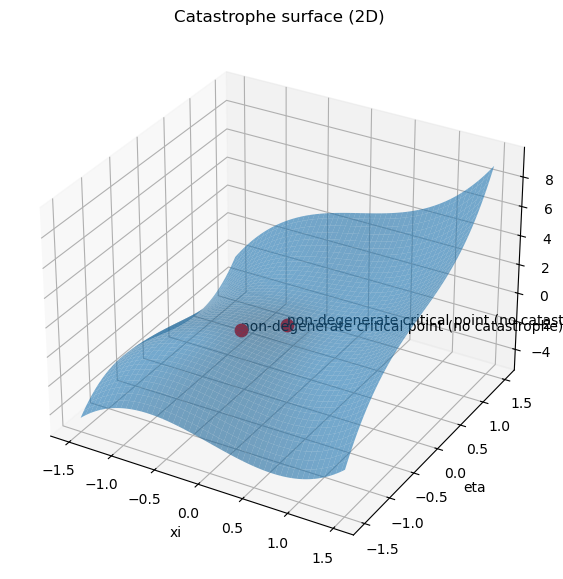


  Using parameters a=0.1, b=-0.1 (slightly perturbed)
  Found 2 critical point(s).


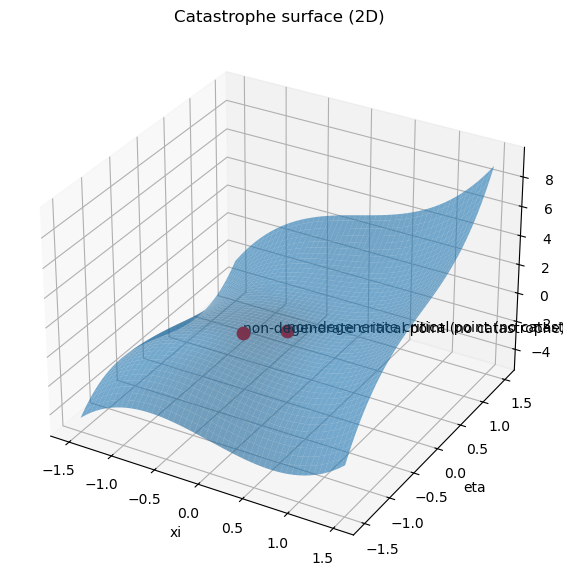

In [13]:
try:
    xi, eta, a, b = sp.symbols('xi eta a b', real=True)
    H_umb_param = xi**3 + eta**3 + xi*eta + a*xi + b*eta

    # Fixer un point dans l'espace des paramètres proche de la bifurcation
    a_val, b_val = 0.0, 0.0  # Point critique exact
    H_fixed = H_umb_param.subs({a: a_val, b: b_val})

    print(f"  Using parameters a={a_val}, b={b_val} (exact D4+ point)")
    pts = detect_catastrophes(H_fixed, (xi, eta))
    print(f"  Found {len(pts)} critical point(s).")

    plot_catastrophe(H_fixed, (xi, eta), pts, xi_bounds=(-1.5, 1.5), eta_bounds=(-1.5, 1.5))

    # Maintenant, un point légèrement déplacé → on voit 3 points !
    a_val2, b_val2 = 0.1, -0.1
    H_fixed2 = H_umb_param.subs({a: a_val2, b: b_val2})
    pts2 = detect_catastrophes(H_fixed2, (xi, eta))
    print(f"\n  Using parameters a={a_val2}, b={b_val2} (slightly perturbed)")
    print(f"  Found {len(pts2)} critical point(s).")
    plot_catastrophe(H_fixed2, (xi, eta), pts2, xi_bounds=(-1.5, 1.5), eta_bounds=(-1.5, 1.5))

except Exception as e:
    print(f"  FAILED or SKIPPED: {e}")

### Plotting Catastrophes

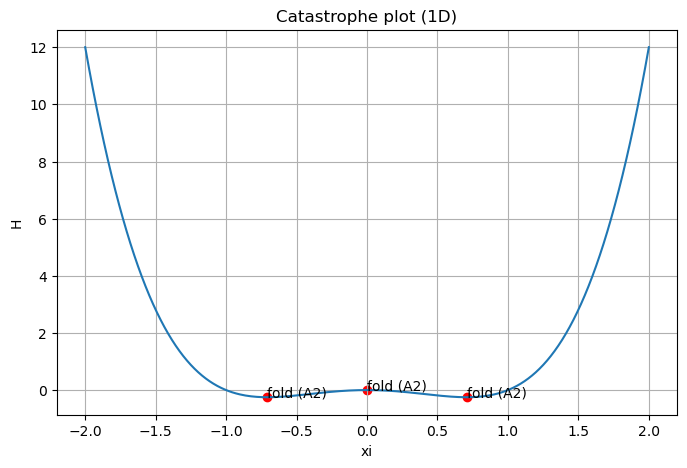

  1D plot generated.


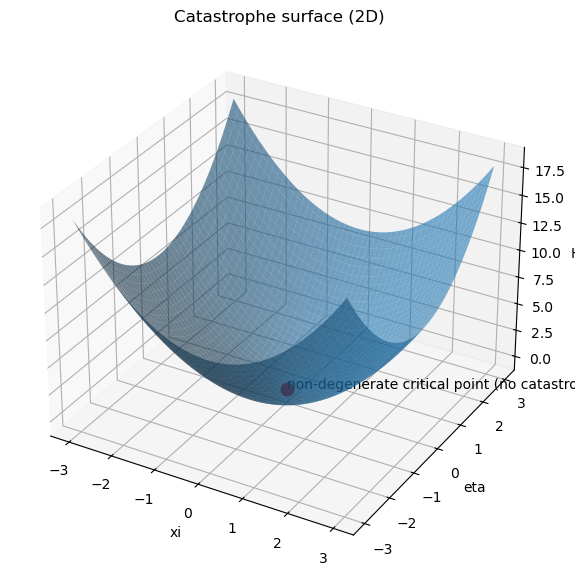

  2D plot generated.


In [14]:
try:
     H_plot = xi**4 - 1*xi**2 # From Test 8
     pts_plot = detect_catastrophes(H_plot.subs(a,1), (xi,))
     plot_catastrophe(H_plot.subs(a,1), (xi,), pts_plot, xi_bounds=(-2, 2))
     print("  1D plot generated.")
     # For 2D, you need a 2D H
     H_plot_2d = xi**2 + eta**2 # Simple minimum
     pts_plot_2d = detect_catastrophes(H_plot_2d, (xi, eta))
     plot_catastrophe(H_plot_2d, (xi, eta), pts_plot_2d)
     print("  2D plot generated.")
except RuntimeError as e:
     print(f"  SKIPPED: {e}")
except Exception as e:
     print(f"  FAILED: {e}")

### Plot Hyperbolic Umbilic (D4+)

  Found 2 critical point(s).


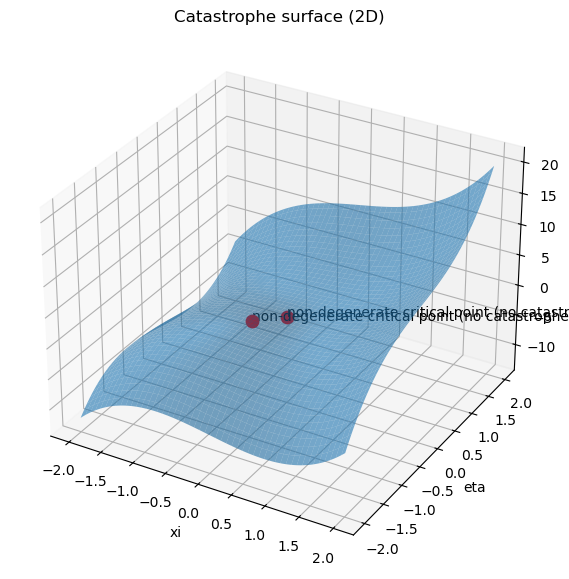

In [15]:
try:
    xi, eta = sp.symbols('xi eta', real=True)
    H_d4p = xi**3 + eta**3 + xi*eta
    pts_d4p = detect_catastrophes(H_d4p, (xi, eta))
    print(f"  Found {len(pts_d4p)} critical point(s).")
    plot_catastrophe(H_d4p, (xi, eta), pts_d4p, xi_bounds=(-2, 2), eta_bounds=(-2, 2))
except Exception as e:
    print(f"  FAILED or SKIPPED: {e}")

### Plot Swallowtail (A4)

  Found 4 real critical point(s).


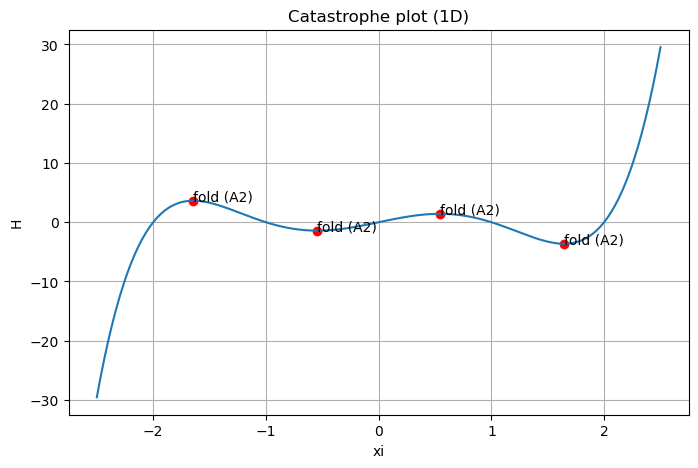

In [16]:
try:
    xi = sp.symbols('xi', real=True)
    # Ce H a ∂H/∂xi = 5xi^4 - 15xi^2 + 4, qui a 4 racines réelles distinctes
    H_sw = xi**5 - 5*xi**3 + 4*xi
    pts_sw = detect_catastrophes(H_sw, (xi,))
    print(f"  Found {len(pts_sw)} real critical point(s).")
    plot_catastrophe(H_sw, (xi,), pts_sw, xi_bounds=(-2.5, 2.5))
except Exception as e:
    print(f"  FAILED or SKIPPED: {e}")

## Arnold 2D Classification

### Morse (Non-Degenerate Minimum)

In [17]:
H_morse_min = xi**2 + eta**2
point_morse_min = {"xi": 0, "eta": 0}
res_morse_min = classify_arnold_2d(H_morse_min, xi, eta, point_morse_min)
expected_type_min = "Morse (non-degenerate)"
print(f"  Type found: {res_morse_min['type']}")
print(f"  Expected: {expected_type_min}")
print(f"  Match: {res_morse_min['type'] == expected_type_min}")

  Type found: Morse (non-degenerate)
  Expected: Morse (non-degenerate)
  Match: True


### Morse (Non-Degenerate Maximum)

In [18]:
H_morse_max = -xi**2 - eta**2
res_morse_max = classify_arnold_2d(H_morse_max, xi, eta, point_morse_min)
expected_type_max = "Morse (non-degenerate)"
print(f"  Type found: {res_morse_max['type']}")
print(f"  Expected: {expected_type_max}")
print(f"  Match: {res_morse_max['type'] == expected_type_max}")

  Type found: Morse (non-degenerate)
  Expected: Morse (non-degenerate)
  Match: True


### A3 (Cusp-family)

In [19]:
H_a3 = xi**4 + eta**2
point_a3 = {"xi": 0, "eta": 0}
res_a3 = classify_arnold_2d(H_a3, xi, eta, point_a3)
expected_type_a3 = "A3 (Cusp)"  # or "A3 Cusp-family" depending on the final version
print(f"  Type found: {res_a3['type']}")
print(f"  Expected: {expected_type_a3}")
# Approximate type verification
match_a3 = "A3" in res_a3['type']
print(f"  Expected substring 'A3' found: {match_a3}")

  Type found: A3 (Cusp)
  Expected: A3 (Cusp)
  Expected substring 'A3' found: True


### A4 (Swallowtail)

In [20]:
H_a4 = xi**5 + eta**2
point_a4 = {"xi": 0, "eta": 0}
res_a4 = classify_arnold_2d(H_a4, xi, eta, point_a4)
expected_type_a4 = "A4 (Swallowtail)"
print(f"  Type found: {res_a4['type']}")
print(f"  Expected: {expected_type_a4}")
match_a4 = "A4" in res_a4['type']
print(f"  Expected substring 'A4' found: {match_a4}")

  Type found: A4 (Swallowtail)
  Expected: A4 (Swallowtail)
  Expected substring 'A4' found: True


### A5 (Butterfly)

In [21]:
H_a5 = xi**6 + eta**2
point_a5 = {"xi": 0, "eta": 0}
res_a5 = classify_arnold_2d(H_a5, xi, eta, point_a5)
expected_type_a5 = "A5 (Butterfly)"
print(f"  Type found: {res_a5['type']}")
print(f"  Expected: {expected_type_a5}")
match_a5 = "A5" in res_a5['type']
print(f"  Expected substring 'A5' found: {match_a5}")

  Type found: A5 (Butterfly)
  Expected: A5 (Butterfly)
  Expected substring 'A5' found: True


### D4+ (Hyperbolic Umbilic)

In [22]:
H_d4p_norm = xi**3 + 3*xi*eta**2 # Standard normal form
point_d4p_norm = {"xi": 0, "eta": 0}
res_d4p_norm = classify_arnold_2d(H_d4p_norm, xi, eta, point_d4p_norm)
expected_type_d4p_norm = "D4 degenerate (I=0) or higher (E6?)" # or a specific message for I=0
print(f"  Type found: {res_d4p_norm['type']}")
print(f"  Expected: {expected_type_d4p_norm} (as I should be 0 for this normal form)")
# Check if I is indeed 0
I_calc = res_d4p_norm.get('cubic_invariant_I', None)
if I_calc is not None:
    print(f"  Calculated cubic invariant I = {I_calc:.4f} (should be 0 for this normal form)")
    print(f"  I ≈ 0: {abs(I_calc) < 1e-8}")

  Type found: D4 degenerate (I=0) or higher (E6?)
  Expected: D4 degenerate (I=0) or higher (E6?) (as I should be 0 for this normal form)
  Calculated cubic invariant I = 0.0000 (should be 0 for this normal form)
  I ≈ 0: True


### D4- (Elliptic Umbilic)

In [23]:
H_d4m_norm = xi**3 - 3*xi*eta**2 # Standard normal form
point_d4m_norm = {"xi": 0, "eta": 0}
res_d4m_norm = classify_arnold_2d(H_d4m_norm, xi, eta, point_d4m_norm)
expected_type_d4m_norm = "D4 degenerate (I=0) or higher (E6?)" # or a specific message for I=0
print(f"  Type found: {res_d4m_norm['type']}")
print(f"  Expected: {expected_type_d4m_norm} (as I should be 0 for this normal form)")
# Check if I is indeed 0
I_calc = res_d4m_norm.get('cubic_invariant_I', None)
if I_calc is not None:
    print(f"  Calculated cubic invariant I = {I_calc:.4f} (should be 0 for this normal form)")
    print(f"  I ≈ 0: {abs(I_calc) < 1e-8}")

  Type found: D4 degenerate (I=0) or higher (E6?)
  Expected: D4 degenerate (I=0) or higher (E6?) (as I should be 0 for this normal form)
  Calculated cubic invariant I = 0.0000 (should be 0 for this normal form)
  I ≈ 0: True


### A4 (Swallowtail)

In [24]:
H_a4_complex = 2*xi**4 + 2*xi**2*eta**2 + eta**4
point_a4_complex = {"xi": 0, "eta": 0}
res_a4_complex = classify_arnold_2d(H_a4_complex, xi, eta, point_a4_complex)
print(f"  H = {H_a4_complex}")
print(f"  Type found: {res_a4_complex['type']}")
print(f"  Note: Complex case, result is '{res_a4_complex['type']}' for inspection.")

  H = eta**4 + 2*eta**2*xi**2 + 2*xi**4
  Type found: D4 degenerate (I=0) or higher (E6?)
  Note: Complex case, result is 'D4 degenerate (I=0) or higher (E6?)' for inspection.


## Bifurcation Curve

  Computing minima over 60 λ values in parallel...


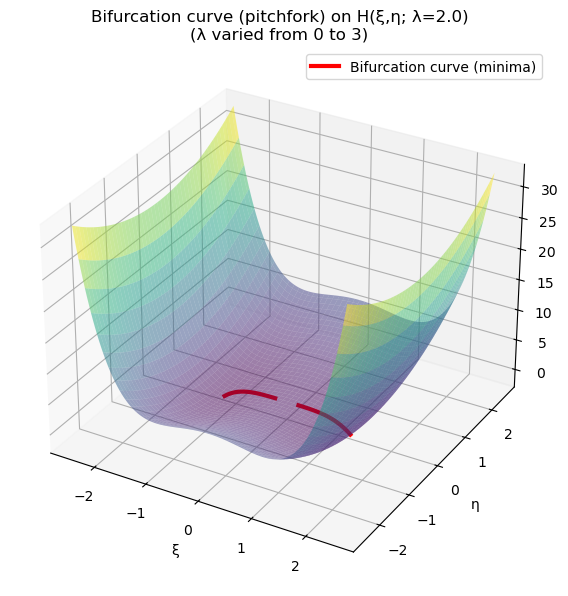

  Successfully plotted bifurcation curve with 116 minima points (computed in parallel).


In [36]:
import matplotlib.pyplot as _plt
import numpy as np
import sympy as sp
from concurrent.futures import ProcessPoolExecutor, as_completed

xi, eta, lam = sp.symbols('xi eta lam', real=True)
H_pitchfork = xi**4 - lam*xi**2 + eta**2
lam_ref = 2.0
H_ref = H_pitchfork.subs(lam, lam_ref)

# === Fonction indépendante pour un seul lambda ===
def _compute_minima_for_lambda(lv):
    """Fonction sérialisable pour ProcessPoolExecutor."""
    H_inst = xi**4 - lv*xi**2 + eta**2  # Reconstruire H localement
    pts = detect_catastrophes(H_inst, (xi, eta), method="numeric")

    H_at_origin = float(H_inst.subs({xi: 0, eta: 0}))
    minima = []
    for p in pts:
        xv = p["point"][xi]
        yv = p["point"][eta]
        Hv = float(H_inst.subs({xi: xv, eta: yv}))
        if Hv < H_at_origin - 1e-3:
            minima.append((xv, yv, Hv))
    return minima

# === Parallélisation ===
lam_vals = np.linspace(0.0, 3.0, 60)
# Dictionnaire pour stocker les résultats dans le désordre
results_dict = {} 

print(f"  Computing minima over {len(lam_vals)} λ values in parallel...")
with ProcessPoolExecutor() as executor:
    future_to_lam = {executor.submit(_compute_minima_for_lambda, float(lv)): float(lv) for lv in lam_vals}
    for future in as_completed(future_to_lam):
        lv = future_to_lam[future] # Récupérer le lambda associé
        try:
            minima_list = future.result()
            # Stocker les résultats par lambda
            results_dict[lv] = minima_list 
        except Exception as e:
            print(f"    Warning: λ={lv:.2f} failed: {e}")

# === Post-traitement : Trier et séparer les branches ===
bif_branch1_x, bif_branch1_y, bif_branch1_z = [], [], []
bif_branch2_x, bif_branch2_y, bif_branch2_z = [], [], []

# Trier par lambda (la clé du dictionnaire)
for lv in sorted(results_dict.keys()):
    minima_list = results_dict[lv]
    
    # On s'attend à 0 ou 2 minima (la fourche)
    if len(minima_list) == 2:
        # Trier les 2 points par xi pour séparer les branches
        pts = sorted(minima_list, key=lambda p: p[0]) # p[0] est xv
        
        p_neg = pts[0] # Branche 1 (xi négatif)
        p_pos = pts[1] # Branche 2 (xi positif)
        
        bif_branch1_x.append(p_neg[0])
        bif_branch1_y.append(p_neg[1])
        bif_branch1_z.append(p_neg[2])

        bif_branch2_x.append(p_pos[0])
        bif_branch2_y.append(p_pos[1])
        bif_branch2_z.append(p_pos[2])

# === Tracer la surface + courbe ===
xi_bounds = (-2.5, 2.5)
eta_bounds = (-2.5, 2.5)
n = 150
X = np.linspace(xi_bounds[0], xi_bounds[1], n)
Y = np.linspace(eta_bounds[0], eta_bounds[1], n)
XX, YY = np.meshgrid(X, Y)
Hf_ref = sp.lambdify((xi, eta), H_ref, "numpy")
ZZ = Hf_ref(XX, YY)

fig = _plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ, alpha=0.5, cmap='viridis', edgecolor='none')

# Tracer les DEUX branches séparément
ax.plot(bif_branch1_x, bif_branch1_y, bif_branch1_z, 'r-', linewidth=3, label='Bifurcation curve (minima)')
ax.plot(bif_branch2_x, bif_branch2_y, bif_branch2_z, 'r-', linewidth=3) # Pas besoin de label ici

ax.set_xlabel('ξ')
ax.set_ylabel('η')
ax.set_zlabel('H')
ax.set_title(f'Bifurcation curve (pitchfork) on H(ξ,η; λ={lam_ref})\n(λ varied from 0 to 3)')
ax.legend()
_plt.show()

total_minima = len(bif_branch1_z) + len(bif_branch2_z)
print(f"  Successfully plotted bifurcation curve with {total_minima} minima points (computed in parallel).")

### Caustic of the Elliptic Umbilic (D4-)

  Computing critical points over 80 'a' values in parallel...


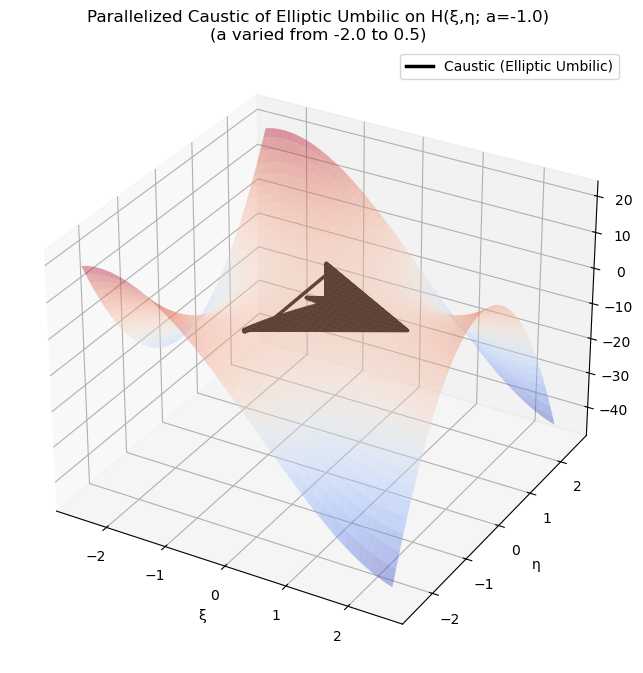

  Successfully plotted caustic with 320 critical points (computed in parallel).


In [34]:
xi, eta, a = sp.symbols('xi eta a', real=True)
H_umb = xi**3 - 3*xi*eta**2 + a*(xi**2 + eta**2)
a_ref = -1.0
H_ref = H_umb.subs(a, a_ref)

# === Fonction indépendante pour un seul 'a' ===
def _compute_critical_points_for_a(av):
    """Fonction sérialisable pour ProcessPoolExecutor."""
    H_inst = xi**3 - 3*xi*eta**2 + av*(xi**2 + eta**2)  # Reconstruire H localement
    pts = detect_catastrophes(H_inst, (xi, eta), method="numeric")
    results = []
    for p in pts:
        xv = p["point"][xi]
        yv = p["point"][eta]
        Hv = float(H_inst.subs({xi: xv, eta: yv}))
        results.append((xv, yv, Hv))
    return results

# === Parallélisation ===
a_vals = np.linspace(-2.0, 0.5, 80)
results_dict = {}
print(f"  Computing critical points over {len(a_vals)} 'a' values in parallel...")
with ProcessPoolExecutor() as executor:
    future_to_a = {executor.submit(_compute_critical_points_for_a, float(av)): float(av) for av in a_vals}
    for future in as_completed(future_to_a):
        av = future_to_a[future]
        try:
            results = future.result()
            results_dict[av] = results
        except Exception as e:
            print(f"    Warning: a={av:.2f} failed: {e}")

# === Post-traitement : Déballer les données ===
caustic_xi, caustic_eta, caustic_H = [], [], []
for av in sorted(results_dict.keys()):
    for (xv, yv, Hv) in results_dict[av]:
        caustic_xi.append(xv)
        caustic_eta.append(yv)
        caustic_H.append(Hv)

# === Tracer la surface + caustique ===
xi_bounds = (-2.5, 2.5)
eta_bounds = (-2.5, 2.5)
n = 150
X = np.linspace(xi_bounds[0], xi_bounds[1], n)
Y = np.linspace(eta_bounds[0], eta_bounds[1], n)
XX, YY = np.meshgrid(X, Y)
Hf_ref = sp.lambdify((xi, eta), H_ref, "numpy")
ZZ = Hf_ref(XX, YY)

fig = _plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ, alpha=0.4, cmap='coolwarm', edgecolor='none')
ax.plot(caustic_xi, caustic_eta, caustic_H, 'k-', linewidth=2.5, label='Caustic (Elliptic Umbilic)')
ax.scatter(caustic_xi[::8], caustic_eta[::8], caustic_H[::8], color='black', s=12)
ax.set_xlabel('ξ')
ax.set_ylabel('η')
ax.set_zlabel('H')
ax.set_title(f'Parallelized Caustic of Elliptic Umbilic on H(ξ,η; a={a_ref})\n(a varied from -2.0 to 0.5)')
ax.legend()
_plt.show()
print(f"  Successfully plotted caustic with {len(caustic_xi)} critical points (computed in parallel).")


### Caustic (Elliptic Umbilic)

  Launching parallel detection over 80 parameter values...


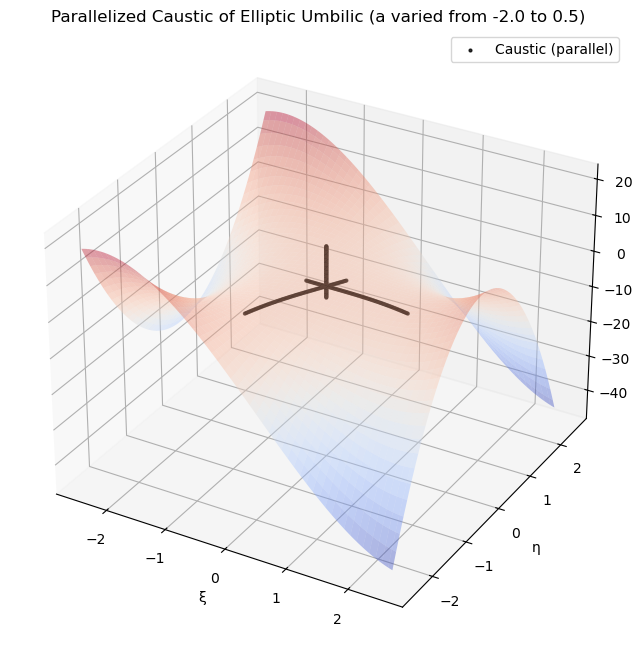

  Successfully collected 320 critical points in parallel.


In [35]:
xi, eta, a = sp.symbols('xi eta a', real=True)
H_umb = xi**3 - 3*xi*eta**2 + a*(xi**2 + eta**2)

# Valeurs du paramètre a
a_vals = np.linspace(-2.0, 0.5, 80)
a_ref = -1.0
H_ref = H_umb.subs(a, a_ref)

# === Fonction indépendante pour un seul a ===
def _compute_critical_points_for_a(av):
    """Fonction sérialisable pour ProcessPoolExecutor."""
    H_inst = H_umb.subs(a, float(av))
    pts = detect_catastrophes(H_inst, (xi, eta), method="numeric")
    results = []
    for p in pts:
        xv = p["point"][xi]
        yv = p["point"][eta]
        Hv = float(H_inst.subs({xi: xv, eta: yv}))
        results.append((xv, yv, Hv))
    return results

# === Parallélisation ===
print(f"  Launching parallel detection over {len(a_vals)} parameter values...")
results_dict = {}
with ProcessPoolExecutor() as executor:
    future_to_a = {executor.submit(_compute_critical_points_for_a, float(av)): float(av) for av in a_vals}
    for future in as_completed(future_to_a):
        av = future_to_a[future]
        try:
            results = future.result()
            results_dict[av] = results
        except Exception as e:
            print(f"    Warning: a={av:.2f} failed: {e}")

# === Post-traitement : Aggregation des résultats ===
caustic_data = []
for av in sorted(results_dict.keys()):
    caustic_data.extend(results_dict[av])

if not caustic_data:
    raise ValueError("No critical points found.")

caustic_xi, caustic_eta, caustic_H = zip(*caustic_data)

# === Préparation de la surface de référence ===
xi_bounds = (-2.5, 2.5)
eta_bounds = (-2.5, 2.5)
n = 150
X = np.linspace(*xi_bounds, n)
Y = np.linspace(*eta_bounds, n)
XX, YY = np.meshgrid(X, Y)
Hf_ref = sp.lambdify((xi, eta), H_ref, "numpy")
ZZ = Hf_ref(XX, YY)

# === Visualisation ===
fig = _plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ, alpha=0.4, cmap='coolwarm', edgecolor='none')
ax.scatter(caustic_xi, caustic_eta, caustic_H, c='k', s=4, alpha=0.8, label='Caustic (parallel)')
ax.set_xlabel('ξ')
ax.set_ylabel('η')
ax.set_zlabel('H')
ax.set_title(f'Parallelized Caustic of Elliptic Umbilic (a varied from -2.0 to 0.5)')
ax.legend()
_plt.show()

print(f"  Successfully collected {len(caustic_data)} critical points in parallel.")
